11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Generator Loss: 0.0000, Discriminator Loss: -6621438.0000
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Generator Loss: 0.0000, Discriminator Loss: -35902628.0000
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Generator Loss: 0.0000, Discriminator Loss: -97043552.0000
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Generator Loss: 0.0000, Discriminator Loss: -198555088.0000
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Generator Loss: 0.0000, Discriminator Loss: -359914176.0000


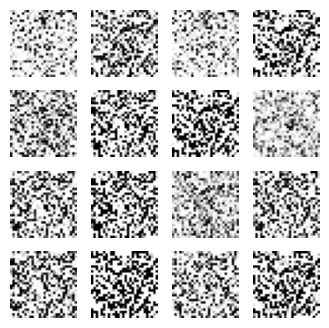

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import os

# Set random seed for reproducibility
tf.random.set_seed(42)

# Hyperparameters
latent_dim = 100
epochs = 50
batch_size = 128
buffer_size = 60000
image_shape = (28, 28, 1)

# Load and preprocess MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5  # Normalize to [-1, 1]
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

# Build the Generator
def build_generator():
    model = models.Sequential([
        layers.Dense(256, input_dim=latent_dim),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(1024),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(np.prod(image_shape), activation='tanh'),
        layers.Reshape(image_shape)
    ])
    return model

# Build the Discriminator
def build_discriminator():
    model = models.Sequential([
        layers.Flatten(input_shape=image_shape),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss =-0.5 * cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Initialize models and optimizers
generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.close()

# Training loop
seed = tf.random.normal([16, latent_dim])

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    for image_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch)

    # Generate images every 10 epochs
    if (epoch + 1) % 10 == 0:
        generate_and_save_images(generator, epoch + 1, seed)
        print(f'Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}')

# Generate final images
generate_and_save_images(generator, epochs, seed)

# Save the generator model
generator.save('generator_model.h5')

# Display final generated images
predictions = generator(seed, training=False)
fig = plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.show()